## prepare data for modeling

In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, auc

from utils import preprocess_data, validate_data

data_location = '../data/raw/psp_raw_data.xlsx'

### retrieve, preprocess and validate data
- feature selection based in previous analysis

In [2]:
df = pd.read_excel(data_location, index_col=0)

# Apply the preprocessing and validation function
df = preprocess_data(df)
print(validate_data(df))
display(df.head())

Validation complete and successful.
None


,country,card,3d_secured,is_peak_time,amount,psp,success
0,Germany,Visa,0,0,89,UK_Card,0
1,Germany,Visa,0,0,89,UK_Card,1
2,Germany,Diners,1,0,238,UK_Card,0
3,Germany,Diners,1,0,238,UK_Card,1
4,Austria,Diners,0,0,124,Simplecard,0


## baseline model 
- no handling imbalance, no hyperparameter tuning, etc

### create model

In [3]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured', 'is_peak_time']
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(lambda x: np.log1p(x), validate=True)), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Create predictions for all PSPs for a single data point
def predict_psp_probabilities(model, preprocessor, new_data, psp_list):
    """
    Predict success probabilities for each PSP for a given input data point.
    """
    results = []
    for psp in psp_list:
        new_data_with_psp = new_data.copy()
        new_data_with_psp['psp'] = psp  # Set PSP
        preprocessed = preprocessor.transform(new_data_with_psp)
        prob = model.predict_proba(preprocessed)[:, 1][0]  # Probability of success
        results.append((psp, prob))
    return results

Validation complete and successful.
None


### evaluate model

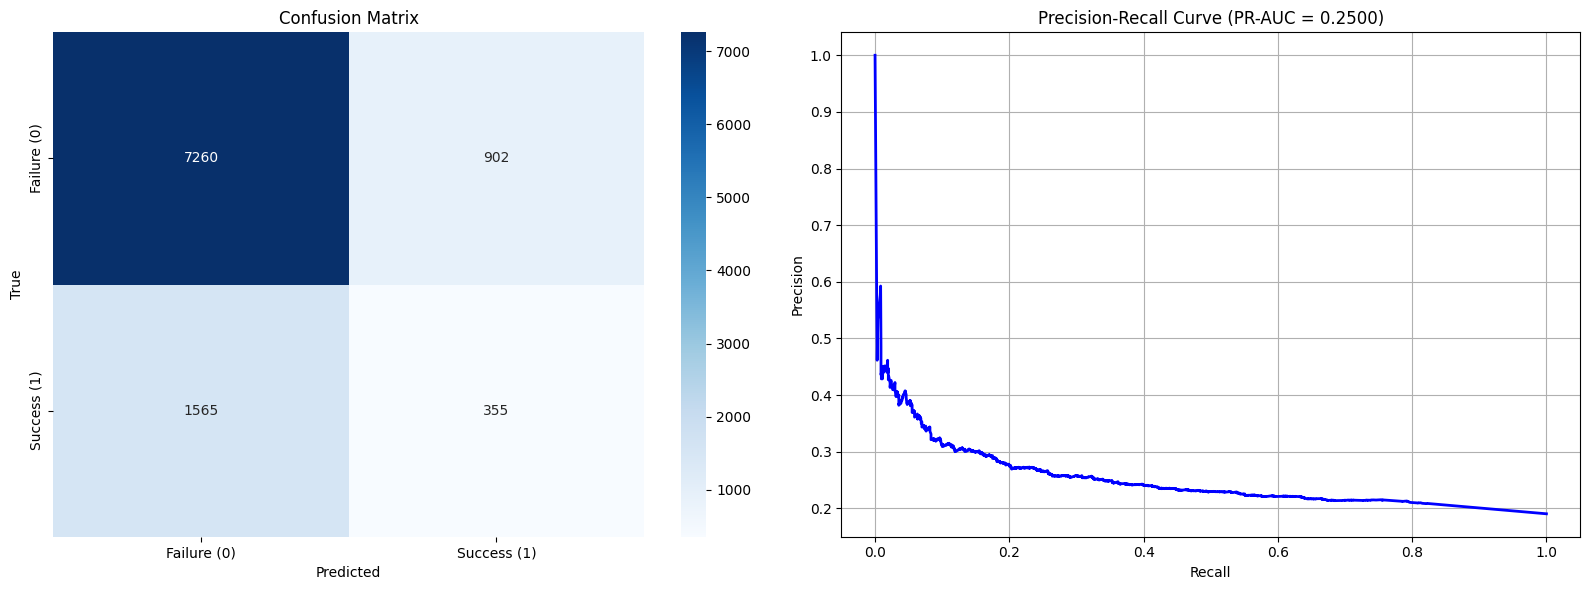


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.822663,0.889488,0.854771,8162.000000
Success (1),0.282418,0.184896,0.223481,1920.000000
accuracy,0.755306,0.755306,0.755306,0.755306
macro avg,0.552541,0.537192,0.539126,10082.000000
weighted avg,0.719780,0.755306,0.734549,10082.000000


Best F1-Score: 0.3356 at Threshold: 0.0083
Total Model F1-Score: 0.2235
Total Model Precision: 0.2824


In [4]:
# Evaluate model predictions
y_test_pred = pipeline.predict(X_test)
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 2. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failure (0)', 'Success (1)'], 
            yticklabels=['Failure (0)', 'Success (1)'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix')

# Plot Precision-Recall Curve
axes[1].plot(recall, precision, color='blue', lw=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve (PR-AUC = {pr_auc:.4f})')
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# 3. Classification Report (Precision, Recall, F1-Score)
report = classification_report(y_test, y_test_pred, target_names=['Failure (0)', 'Success (1)'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
display(report_df)

# Find threshold for best F1-Score
valid_mask = (precision + recall) > 0
f1_scores = 2 * (precision[valid_mask] * recall[valid_mask]) / (precision[valid_mask] + recall[valid_mask])
valid_thresholds = thresholds[valid_mask[:-1]]  # Match length with thresholds

# Find the best threshold
if f1_scores.size > 0:  # Ensure there's at least one valid F1-score
    best_f1 = f1_scores.max()
    best_threshold = valid_thresholds[f1_scores.argmax()]
    print(f"Best F1-Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")
else:
    print("No valid F1-scores could be calculated.")

# 4. Total F1-Score
f1 = f1_score(y_test, y_test_pred, pos_label=1)
print(f"Total Model F1-Score: {f1:.4f}")

# 5. Overall Precision
precision = precision_score(y_test, y_test_pred, average='binary', pos_label=1)
print(f"Total Model Precision: {precision:.4f}")


### use model

In [5]:
# Simulate a new data point
new_data = pd.DataFrame({
    'country': ['Germany'],
    'card': ['Visa'],
    'amount': [100],
    '3d_secured': [1],
    'is_peak_time': [0]
})

# Get all unique PSPs
psp_list = df['psp'].unique()

# Predict probabilities
probabilities = predict_psp_probabilities(
    model=pipeline.named_steps['classifier'], 
    preprocessor=pipeline.named_steps['preprocessor'], 
    new_data=new_data, 
    psp_list=psp_list
)

# Create a DataFrame for the input features
input_data_df = new_data.reset_index(drop=True)
# Create a DataFrame for probabilities
probabilities_df = pd.DataFrame(probabilities, columns=['PSP', 'Probability'])

# Create a dictionary from probabilities for easy column assignment
prob_dict = dict(probabilities)

# Add the probabilities as new columns to the input data
for psp, prob in prob_dict.items():
    input_data_df[psp] = prob

# Output the final DataFrame
print("Predicted probabilities for each PSP:")
display(input_data_df)

Predicted probabilities for each PSP:


,country,card,amount,3d_secured,is_peak_time,UK_Card,Simplecard,Moneycard,Goldcard
0,Germany,Visa,100,1,0,0.8275,0.936667,0.01,0.19
